In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import random 
import gymnasium as gym

In [3]:
# for displaying result

import os
import matplotlib.pyplot as plt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

### Algorithm
1. Initialize replay memory <br>
2. Initialize action-value function Q with random weights <br>
3. Initialize target action-value function Q' with the same weights as Q<br>
4. For each episode:
    a. Reset environment to initial state<br>
    b. For each time step:<br>
    i. With probability epsilon select a random action, otherwise <br>select the action with the highest Q-value<br>
    ii. Execute the selected action in the environment and observe<br> the next state and reward<br>
    iii. Store the transition in replay memory<br>
    iv. Sample a random mini-batch of transitions from replay memory<br>
    v. Calculate the target Q-value for each transition<br>
    vi. Update the weights of the Q function using the mini-batch of transitions and the calculated target Q-values<br>
    vii. Every C steps, update the target Q function by copying the weights from Q to Q'<br>
    c. End episode when environment is done<br>

### Replay Memory


This is a data structure to store the experience tuples (state, action, reward, next state) 
that the agent observes. The size of the replay memory is typically limited, and old experiences are 
replaced by new ones.


In [4]:

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        
        self.memory = []
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.memory.append(data)
        # replace old experience, if memory is full
        if (len(self.memory) > self.capacity):
            self.memory.pop(0) 
    
    def get_batch(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.memory)
        

### Action-value Function

This is a neural network that takes a state as input and outputs the Q-value for each action. The weights of the neural network are initialized randomly.

They are of 2 types:

1. Action-value function Q 
2. Target Action-value function Q':
   This is a copy of the Q neural network with the same weights. It is used to calculate the target Q-values for the update step.

In [5]:
class QNet(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# as q` gets its weight from q, let's make a utility update function

def update_weights(q, q_):
    q_.load_state_dict(q.state_dict())

#### Description
This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

#### Action Space
The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

0: Push cart to the left
1: Push cart to the right

`Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it`

#### Observation Space
The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:


##### Observation

1. Cart Position

2. Cart Velocity

3. Pole Angle

4. Pole Angular Velocity


Note: While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

The cart x-position (index 0) can be take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.
The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°)


#### Rewards
Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 475 for v1.

#### Starting State
All observations are assigned a uniformly random value in (-0.05, 0.05)

#### Episode End
The episode ends if any one of the following occurs:

Termination: Pole Angle is greater than ±12°
Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
Truncation: Episode length is greater than 500 (200 for v0)


In [6]:
# setup ENV
env = gym.make('CartPole-v1', render_mode="rgb_array")
# observation space
# cart position, cart velocity, pole angle, pole angular velocity
state_size = env.observation_space.shape[0]

#action space
# left, right
action_size = env.action_space.n

In [11]:
# v. Calculate the target Q-value for each transition
# vi. Update the weights of the Q function using the mini-batch of transitions and the calculated target Q-values

def train(batch, dqn, target_dqn, optimizer, gamma):
    states, actions, rewards, next_states, dones = batch
    Q = dqn(states)
    Q = Q.gather(1, actions)
    Q_next = target_dqn(next_states).max(1)[0].detach()
    target = rewards + (1 - dones) * gamma * Q_next.unsqueeze(1)
    loss = F.mse_loss(Q, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

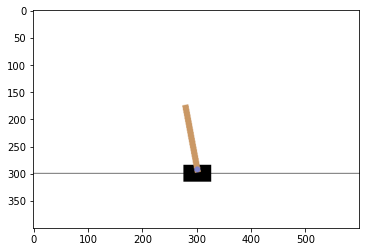

28.0


In [ ]:
# hyper-parameters
replay_capacity = 10000
batch_size = 3
num_episodes = 1000
max_steps = 500

# Initialize replay memory
replay = ReplayMemory(replay_capacity)

# Initialize action-value function Q with random weights
dqn = QNet(state_size, action_size).to(device)
dqn_ = QNet(state_size, action_size).to(device)

# Initialize target action-value function Q' with the same weights as Q
update_weights(dqn, dqn_)

# optimizer 
lr = 0.001
optimizer = optim.Adam(dqn.parameters(), lr=lr)
target_update = 10
gamma = 0.99 # determines the importance of next steps rewards

# epsilon
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995


# For each episode:

for episode in range(num_episodes):
    # a. Reset environment to initial state
    state, _ = env.reset()
    
    score = 0
    # b. For each time step
    for t in range(max_steps):
        # i. With probability epsilon select a random action, 
        #    otherwise select the action with the highest Q-value
        if epsilon > random.random():
            action = env.action_space.sample()
        else:
            action = dqn(torch.FloatTensor(state)).argmax().item()
        
        # ii. Execute the selected action in the environment 
        # and observe the next state and reward

        next_state, reward, done, _, _ = env.step(action)
        score += reward
        
        # iii. Store the transition in replay memory
        replay.push(state, action, reward, next_state, done)
        
        # step v and vi is training the neural network
        # executing this in separate function
        if len(replay) > batch_size:
            # iv. Sample a random mini-batch of transitions from replay memory
            batch = replay.get_batch(batch_size)
            states, actions, rewards, next_states, dones = batch
            train(batch, dqn, dqn_, optimizer, gamma)
            
        # vii. Every C steps, update the target Q function 
        # by copying the weights from Q to Q'
        
        if t % target_update == 0:
            update_weights(dqn, dqn_)
        
        print(score)
        clear_output(wait=True)
        plt.imshow( env.render() )
        plt.show()
        if done:
            break
    
    # track scores

    # update epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    
    # print progress
#     print(f"{episode + 1}/{num_episodes}")